In [1]:
import numpy as np
import os
import cv2
import h5py
import struct
import vtk
import vtk.util
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from volume_extraction import *
from utilities import *
from VTKFunctions import *
from GradDesOrient import *
from scipy.ndimage import affine_transform, rotate, zoom, shift
#from joblib import Parallel, delayed

from ipywidgets import FloatProgress
from IPython.display import display

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\cntk\cntk_py_init.py:84: UserWarning: 

################################################ Missing optional dependency (GPU-Specific) ################################################
   CNTK may crash if the component that depends on those dependencies is loaded.
   Visit https://docs.microsoft.com/en-us/cognitive-toolkit/Setup-Windows-Python#optional-gpu-specific-packages for more information.
############################################################################################################################################
If you intend to use CNTK without GPU support, you can ignor

### Pipeline debugging

Sample name: 15_L6TL_2
1. Load sample


FloatProgress(value=0.0, description='Loading:', max=625.0)

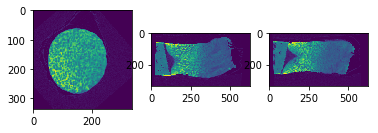

In [2]:
# Parameters
#path = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_PTA_48h_Rec\24_R6LT_2_PTA_48h_Rec\Registration"
#mask = r"Z:\3DHistoData\rekisteroidyt\24_R6LT_2_CA4+_Rec\24_R6LT_2_CA4+_Rec\Suoristettu\Registration\bone_mask"
path = r"Z:\3DHistoData\Test data\24_R6LT_2_binned"
#maskpath = r"Z:\3DHistoData\Test data\21_L3L_binned\bonemask"
maskpath = None
savepath = r"Z:\3DHistoData\SurfaceImages"
modelpath = r"Z:\Tuomas\cntkunet.model"
sample = '15_L6TL_2'
modelpath = None
threshold = 80
size = [100, 10, 5] # width, depth, offset

print('Sample name: ' + sample); print('1. Load sample')
data, bounds = Load(path)
PrintOrthogonal(data)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_input.png", data)
if maskpath is not None and modelpath is None:
    print(maskpath)
    mask, _ = Load(maskpath)
    PrintOrthogonal(mask)

2. Orient sample


FloatProgress(value=0.0, description='Orienting:')

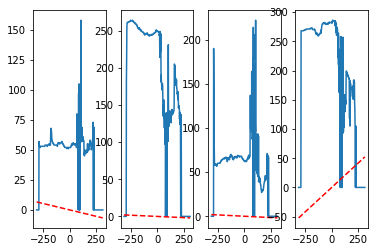

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


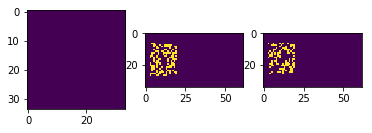

BBox angles: [-0.795161], [4.564634]
PCA angles: [[4.62088481]], [[2.49746329]]
Gradient descent angles: 0.0, 0.0
Gradient descent selected.


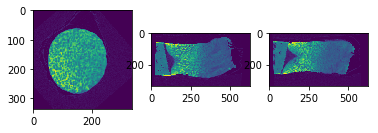

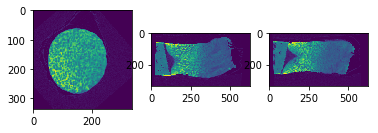

In [3]:
# Orient array
print('2. Orient sample')
ori, angles = Orient(data, bounds)
PrintOrthogonal(ori)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient.png", ori)
if maskpath is not None and modelpath is None:
    mask = OrientMask(mask, angles)

3. Crop and flip center volume:


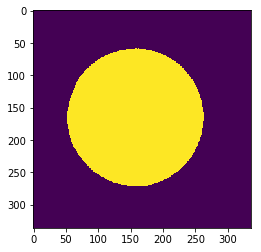

FloatProgress(value=0.0, description='Get center:', max=336.0)

Sum image along z-axis


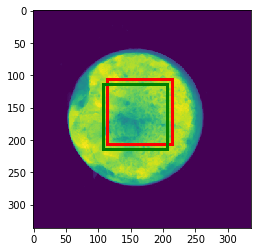

Center moment (green): x = 157, y = 164
Center of mass (red): x = 164.0, y = 156.0


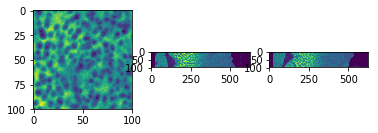

(100, 100, 625)


In [4]:
# Crop and flip volume
print('3. Crop and flip center volume:')
data, crop = CropCenter(ori, threshold, size[0]) # crop data
PrintOrthogonal(data); print(data.shape)
if maskpath is not None and modelpath is None:
    mask = mask[crop[0]:crop[1], crop[2]:crop[3], :] # crop mask
    data = np.flip(data, 2); mask = np.flip(mask, 2) # flip
if modelpath is not None:
    mask = CNTKSegmentation(data, modelpath) # generate mask from crop data
    data = np.flip(data, 2); mask = np.flip(mask, 2) # flip
SaveOrthogonal(savepath + "\\Images\\" + sample + "_orient_cropped.png", data)

4. Get interface coordinates:


FloatProgress(value=0.0, description='Get interface:')

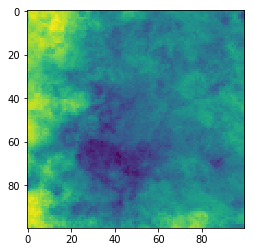

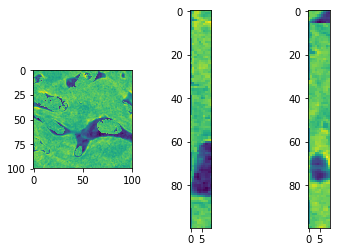

In [5]:
# Get VOIs
print('4. Get interface coordinates:')
surfvoi, interface = GetInterface(data, threshold, size, 'surface', None)
PrintOrthogonal(surfvoi)
SaveOrthogonal(savepath + "\\Images\\" + sample + "_surface.png", surfvoi)
if (maskpath is not None or modelpath is not None) and len(size) == 2:
    print('Offset parameter not given. Setting offset to 0.')
    size.append(0)
if maskpath is not None or modelpath is not None: # Input offset for size[2] to give voi offset from mask interface
    # print("Data shape : {0},{1},{2}".format(data.shape[0],data.shape[1],data.shape[2]))
    # print("Mask shape : {0},{1},{2}".format(mask.shape[0],mask.shape[1],mask.shape[2]))
    deepvoi, ccvoi, interface = GetInterface(data, threshold, size, 'bci', (mask>0.7))
    PrintOrthogonal(deepvoi); PrintOrthogonal(ccvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_deep.png", deepvoi)
    SaveOrthogonal(savepath + "\\Images\\" + sample + "_cc.png", ccvoi)  

5. Save mean and std images


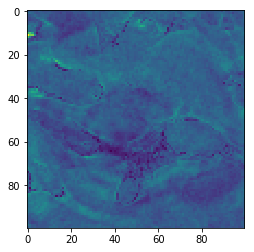

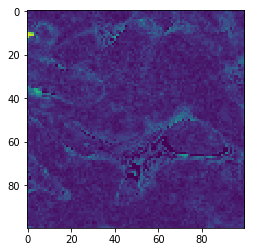

In [6]:
 # 5. Calculate mean and std
print('5. Save mean and std images')
if maskpath is not None or modelpath is not None:
    MeanStd(surfvoi, savepath, sample, deepvoi, ccvoi)
else:
    MeanStd(surfvoi, savepath, sample)

54.2


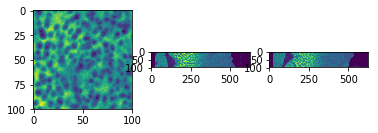

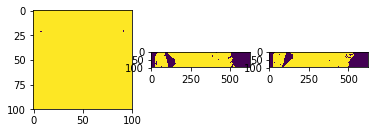

In [18]:
BW1 = data > 70
BW2, val = otsuThreshold(data)
print(val)
PrintOrthogonal(data)
PrintOrthogonal(BW2)
RenderVolume((BW1 ^ BW2)*255)
RenderVolume(data)
#img = surfvoi[:,:,5]
#retval, threshold = cv2.threshold(img.astype('uint8'), 0, 255, cv2.THRESH_OTSU)
#print(retval)
#plt.imshow(threshold)
#plt.show()

73.01


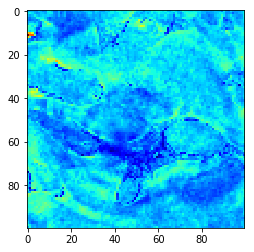

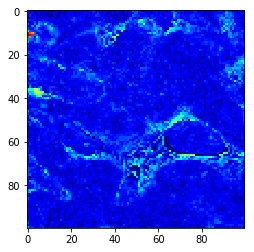

In [17]:
BW1 = surfvoi > 70
BW, val = otsuThreshold(surfvoi)
print(val)
RenderVolume((BW1 ^ BW)*255)
mean = (surfvoi * BW).sum(2) / BW.sum(2)
centered = np.zeros(surfvoi.shape)
for i in range(surfvoi.shape[2]):
    centered[:, :, i] = surfvoi[:, :, i] * BW[:, :, i] - mean
std = np.sqrt(np.sum((centered * BW) ** 2, 2) / (BW.sum(2) - 1 + 1e-9))
plt.imshow(mean, cmap='jet'); plt.show()
plt.imshow(std, cmap='jet'); plt.show()

### Create test object

In [ ]:
savepath = r'Z:\3DHistoData\Test data\Cube2'
test = np.uint8(np.zeros((200,200,500)))
test[20:-20,20:-20,20:-20] = 255
PrintOrthogonal(test)
test2 = test

#RenderVolume(test)
test = rotate(test, 20, (1,2))
PrintOrthogonal(test)
test = rotate(test, -10, (0,2))
PrintOrthogonal(test)

test2 = opencvRotate(test2, 0, 20)
PrintOrthogonal(test2)
test2 = opencvRotate(test2, 1, -10)
PrintOrthogonal(test2)

#xangle = RotationMatrix(np.pi/4, 0)
#yangle = RotationMatrix(-np.pi/4, 1)
#test = affine_transform(test, xangle)
#test = affine_transform(test, yangle)

#Save(savepath, 'Rotated_Cube', test)
#RenderVolume(test)

### VTK rendering example

In [ ]:
# Load and render
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned"
path = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Registration"
mask = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\21_L3L_binned\bonemask"
data, bounds = Load(path)
PrintOrthogonal(data)
RenderVolume(data)

### VTK processing

In [ ]:
# Rotate VTK
array = data[:,:,:]
shape = np.shape(array)
vtkdata = ArrayToVTK(array)
Render(vtkdata)
vtkdata = RotateVTK(vtkdata, [90,0,0])
array2 = VTKToArray(vtkdata, shape)
PrintOrthogonal(array)
PrintOrthogonal(array2 - array)

### H5PY saving example

In [ ]:
# Save to h5
savepath = r"C:\Users\sarytky\Desktop\15_L6TL_2_PTA_48h_Rec\15_L6TL_2_PTA_48h_Rec\Saved"
h5 = h5py.File('filename.h5','w')
h5.create_dataset('mean',data=mean)
h5.create_dataset('std',data=std)
h5.close()

h5 = h5py.File('filename.h5','r')
mean = h5['mean'][:]
h5.close()